In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import explore as e
from importlib import reload
import wrangle as w
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn.cluster import KMeans

In [3]:
reload(w)
df = w.wrangle_zillow(prop_row=.75,prop_col=.5)


In [4]:
train, validate, test = w.tvt_split(df)

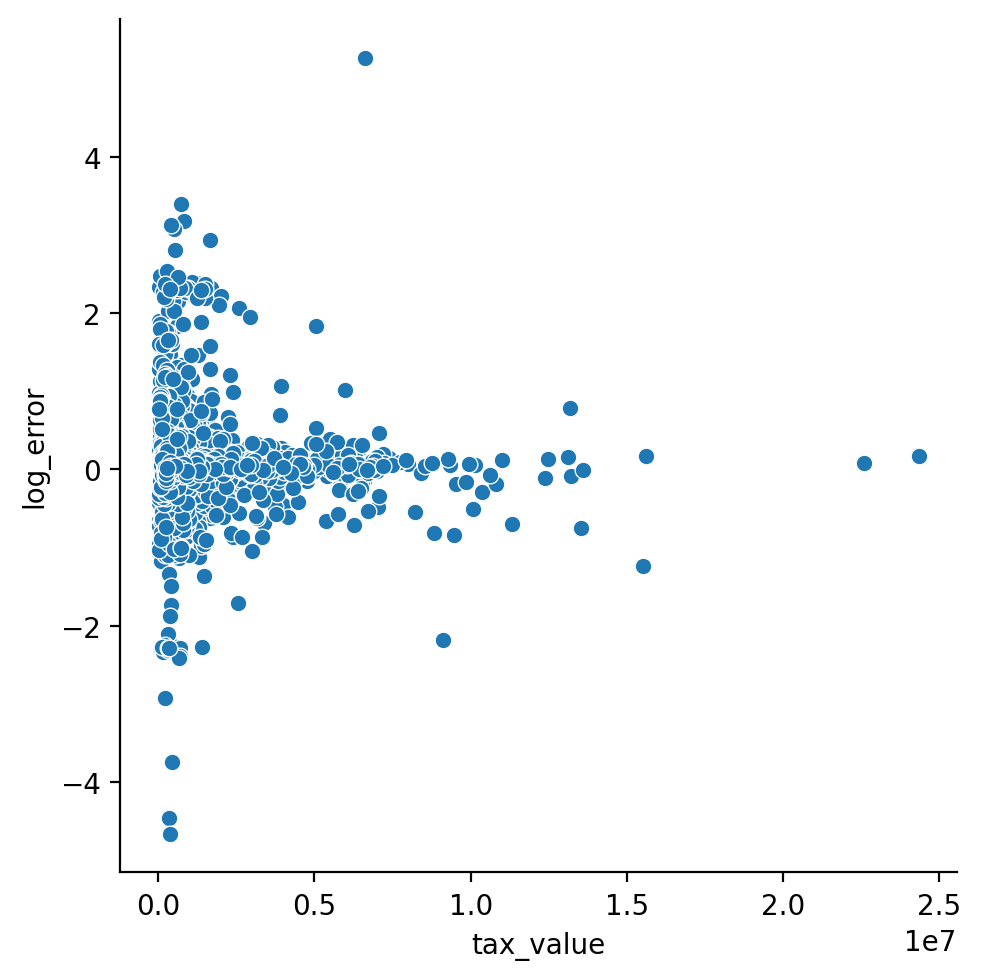

In [5]:

sns.relplot(data=train, x='tax_value', y='log_error')

In [6]:
reload(w)
kmeans = KMeans(7)
x = ['tax_value','latitude','longitude']
scaled_kmeans = w.scale(train,x)
kmeans.fit(scaled_kmeans)
scaled_kmeans['cluster'] = kmeans.predict(scaled_kmeans)
scaled_kmeans['log_error'] = train.log_error

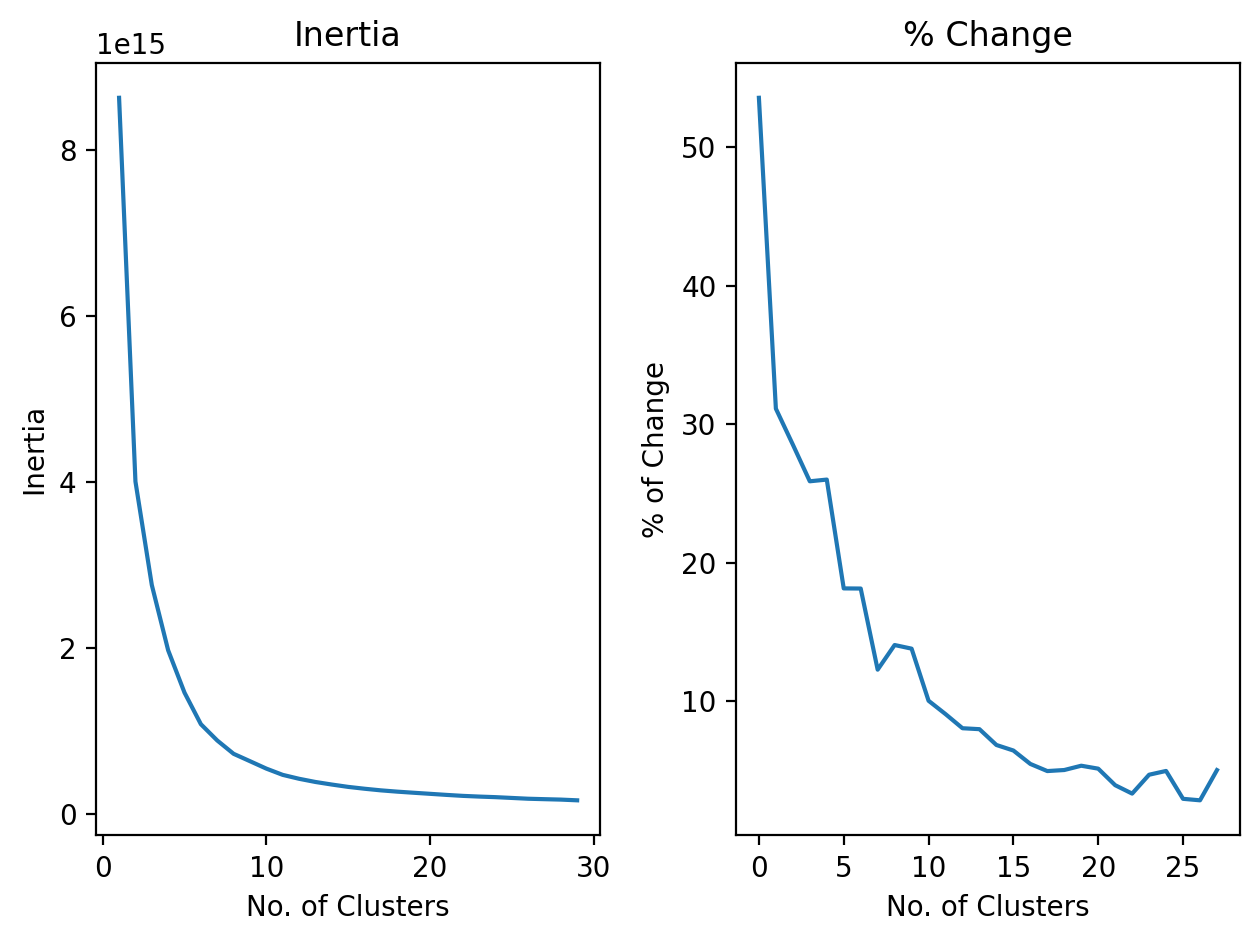

In [24]:
reload(e)
e.generate_elbow(train[['latitude','longitude']])